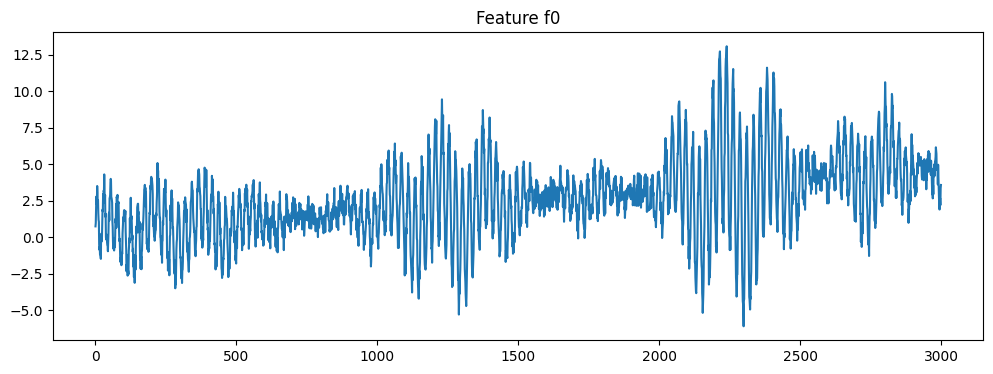

Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 44s 390ms/step - loss: 0.9362 - mae: 0.6968 - val_loss: 1.0754 - val_mae: 0.8209
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - loss: 0.9184 - mae: 0.6902 - val_loss: 1.2445 - val_mae: 0.8853
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - loss: 0.8978 - mae: 0.6858 - val_loss: 0.7795 - val_mae: 0.6550
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - loss: 0.8739 - mae: 0.6808 - val_loss: 1.0339 - val_mae: 0.8622
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - loss: 0.8623 - mae: 0.6787 - val_loss: 0.8884 - val_mae: 0.7827
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - loss: 0.8440 - mae: 0.6752 - val_loss: 0.8721 - val_mae: 0.7160
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - loss: 0.8323 - mae: 0.6721 - val_loss: 0.8641 - val_mae: 0.7539
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 0.8320 - mae: 0.6719 - val_loss: 0.8192 - val_mae: 0.6979
Epoch 9/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/

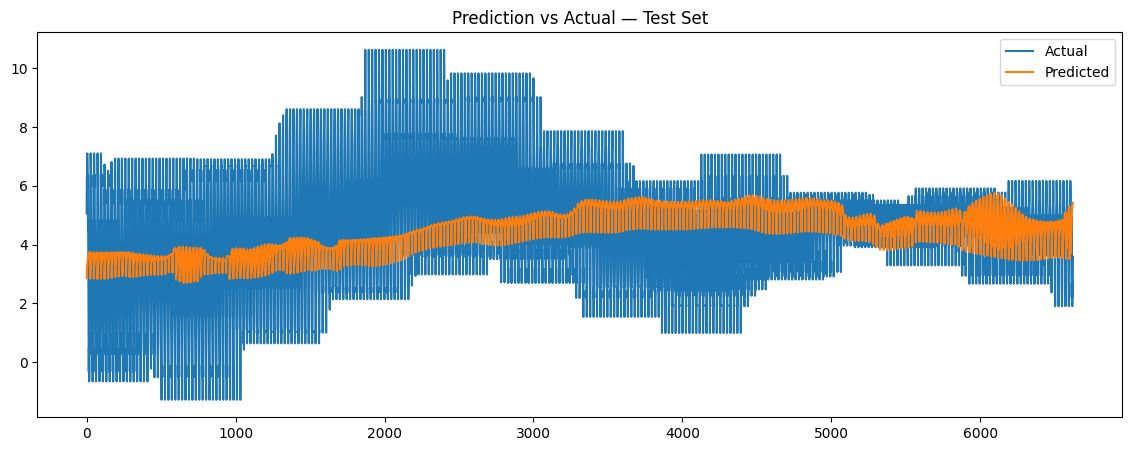


Baseline RMSE Scores:
SARIMAX RMSE : 1.344256146032186
ExpSmooth RMSE: 1.4165851479646903


In [4]:
# ===============================================================
# Google Colab — Single Cell — End-to-End Time Series Forecasting
# Seq2Seq + Attention + Baselines (SARIMAX, Exponential Smoothing)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

# ------------------------------------------------------------
# Synthetic Multivariate Dataset
# ------------------------------------------------------------
def generate_multivariate_series(n_steps=3000, n_features=5, seed=42):
    np.random.seed(seed)
    t = np.arange(n_steps)
    trend = 0.001 * (t ** 1.2)
    data = {}

    for i in range(n_features):
        p1 = 24 + 3 * i
        p2 = 168 + 5 * i
        seasonal1 = 2 * np.sin(2 * np.pi * t / p1)
        seasonal2 = 1 * np.sin(2 * np.pi * t / p2)
        amp = 1 + 0.001 * t * np.sin(2 * np.pi * t / 1000 + i)
        base = 0.5 * (i + 1) + 0.3 * trend
        noise = 0.5 * np.random.randn(n_steps)
        data[f"f{i}"] = base + amp * (seasonal1 + seasonal2) + noise

    df = pd.DataFrame(data)
    df.index.name = "t"
    return df

# ------------------------------------------------------------
# Sliding Window
# ------------------------------------------------------------
def make_windows(df, input_len, output_len, target_col="f0"):
    arr = df.values
    n_samples = len(df) - input_len - output_len + 1

    X = np.zeros((n_samples, input_len, arr.shape[1]), dtype=np.float32)
    y = np.zeros((n_samples, output_len), dtype=np.float32)
    starts = np.zeros(n_samples, dtype=int)

    target_idx = list(df.columns).index(target_col)

    for i in range(n_samples):
        X[i] = arr[i:i+input_len]
        y[i] = arr[i+input_len:i+input_len+output_len, target_idx]
        starts[i] = i

    return X, y, starts

# ------------------------------------------------------------
# Seq2Seq with Global Attention
# ------------------------------------------------------------
def build_seq2seq_attention(input_len, n_features, output_len=24):
    encoder_in = Input(shape=(input_len, n_features))
    enc_out = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(encoder_in)

    # Global attention
    attention = layers.Attention()([enc_out, enc_out])
    context = layers.GlobalAveragePooling1D()(attention)

    repeated = layers.RepeatVector(output_len)(context)
    dec_out = layers.LSTM(64, return_sequences=True, dropout=0.2)(repeated)

    out = layers.TimeDistributed(layers.Dense(1))(dec_out)
    out = layers.Reshape((output_len,))(out)

    model = Model(encoder_in, out)
    model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae"])
    return model

# ------------------------------------------------------------
# Baselines
# ------------------------------------------------------------
def baseline_sarimax(train_series, steps):
    try:
        model = sm.tsa.SARIMAX(
            train_series, order=(1,1,1),
            seasonal_order=(1,1,1,24),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fit = model.fit(disp=False)
        return fit.get_forecast(steps).predicted_mean.values
    except:
        return np.repeat(train_series.iloc[-1], steps)

def baseline_exp_smoothing(train_series, steps):
    try:
        model = ExponentialSmoothing(
            train_series, trend="add", seasonal="add", seasonal_periods=24
        )
        fit = model.fit()
        return fit.forecast(steps).values
    except:
        return np.repeat(train_series.iloc[-1], steps)

# ------------------------------------------------------------
# Validation Fixes
# ------------------------------------------------------------
def validate_data(df):
    df = df.copy()
    df = df.ffill().bfill()
    zero_std = df.columns[df.std() == 0]
    for c in zero_std:
        df[c] += np.random.normal(0, 1e-6, len(df))
    return df

# ------------------------------------------------------------
# Full Training + Evaluation Pipeline
# ------------------------------------------------------------
def train_and_evaluate(df, input_len=168, output_len=24, epochs=25, batch_size=32, target_col="f0"):
    df = validate_data(df)

    n = len(df)
    test_n = int(0.1 * n)
    val_n = int(0.1 * n)

    train_df = df.iloc[:n-test_n-val_n]
    val_df = df.iloc[n-test_n-val_n:n-test_n]
    test_df = df.iloc[n-test_n:]

    scaler = StandardScaler().fit(train_df)
    df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

    X, y, starts = make_windows(df_scaled, input_len, output_len, target_col)

    train_lim = len(train_df)
    val_lim = train_lim + len(val_df)

    train_idx = [i for i,s in enumerate(starts) if s+input_len <= train_lim]
    val_idx   = [i for i,s in enumerate(starts) if train_lim < s+input_len <= val_lim]
    test_idx  = [i for i,s in enumerate(starts) if s+input_len > val_lim]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]
    X_test, y_test   = X[test_idx], y[test_idx]

    model = build_seq2seq_attention(input_len, df.shape[1], output_len)

    cb = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

    model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[cb], verbose=1
    )

    y_pred_scaled = model.predict(X_test)

    idx = list(df.columns).index(target_col)
    mean_t = scaler.mean_[idx]
    scale_t = scaler.scale_[idx]

    y_test_orig = y_test * scale_t + mean_t
    y_pred_orig = y_pred_scaled * scale_t + mean_t

    metrics = {
        "rmse": rmse(y_test_orig.flatten(), y_pred_orig.flatten()),
        "mae": mae(y_test_orig.flatten(), y_pred_orig.flatten()),
        "mape": mape(y_test_orig.flatten(), y_pred_orig.flatten())
    }

    return model, y_test_orig, y_pred_orig, metrics, test_df[target_col].values

# ------------------------------------------------------------
# MAIN EXECUTION
# ------------------------------------------------------------
df = generate_multivariate_series()
plt.figure(figsize=(12,4))
plt.plot(df["f0"])
plt.title("Feature f0")
plt.show()

model, y_true, y_pred, metrics, test_series = train_and_evaluate(df)

print("\nFinal Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k:8} : {v:.4f}")

# ------------------------------------------------------------
# Plot Predictions vs Actual
# ------------------------------------------------------------
plt.figure(figsize=(14,5))
plt.plot(y_true.flatten(), label="Actual")
plt.plot(y_pred.flatten(), label="Predicted")
plt.title("Prediction vs Actual — Test Set")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Optional: Baseline Comparisons
# ------------------------------------------------------------
steps = 24
sarimax_pred = baseline_sarimax(df["f0"].iloc[:-steps], steps)
hw_pred = baseline_exp_smoothing(df["f0"].iloc[:-steps], steps)

print("\nBaseline RMSE Scores:")
print("SARIMAX RMSE :", rmse(test_series[-steps:], sarimax_pred))
print("ExpSmooth RMSE:", rmse(test_series[-steps:], hw_pred))
